# 📖 Neural Autoregressive Distribution Estimation (NADE) – Summary

# https://arxiv.org/pdf/1711.00937

## 🔎 Abstract
The paper introduces **Neural Autoregressive Distribution Estimation (NADE)**, a tractable neural-network-based approach for **density estimation** and **unsupervised learning**.  

**Key contributions:**
- Uses the **autoregressive product rule** to factorize distributions.  
- Employs **weight-sharing inspired by RBMs** to reduce parameters.  
- Extends NADE to:
  - **Binary vectors**  
  - **Real-valued data (RNADE)**  
  - **Deep architectures (DeepNADE)**  
  - **Convolutional models (ConvNADE)**  
- Achieves **competitive log-likelihoods** against RBMs, VAEs, and other state-of-the-art generative models.  
(*Uria et al., 2014+*)

---

## 🎯 Purpose
- Provide a **tractable alternative** to directed/undirected graphical models (RBMs, VAEs, DBNs).  
- Maintain **exact likelihood evaluation** while scaling to high-dimensional data.  
- Extend NADE to handle:
  - Arbitrary variable orderings (**order-agnostic DeepNADE**).  
  - **Image structure (ConvNADE)**.  
  - **Real-valued data** via mixtures of Gaussians (**RNADE**).  

---

## ⚙️ Methodology

### 1. Autoregressive Factorization
Any distribution can be factorized into conditionals:

$$
p(x) = \prod_{d=1}^D p(x_{o_d} \mid x_{o_{<d}})
$$

Each conditional is modeled by a feed-forward NN with **weight sharing**.  

---

### 2. Parameterization

**Hidden states update recursively:**

$$
h_d = \sigma\!\left(W_{\cdot, o_{<d}} \, x_{o_{<d}} + c\right)
$$

**Output distribution:**

$$
p(x_{o_d}=1 \mid x_{o_{<d}}) = \sigma\!\left(V_{o_d, \cdot} \, h_d + b_{o_d}\right)
$$

---

### 3. Training

Optimized with **Maximum Likelihood Estimation (MLE)** via **Negative Log-Likelihood (NLL):**

$$
L = -\frac{1}{N} \sum_{n=1}^N \log p(x^{(n)})
$$

**Complexity reduction:**  

- From $O(HD^2)$ → $O(HD)$.  

---

### 4. Variants
- **RNADE:** Real-valued data → Mixture of Gaussians per conditional.  
- **DeepNADE:** Order-agnostic, supports multiple layers.  
- **EoNADE:** Ensembles of DeepNADE for robustness.  
- **ConvNADE:** Convolutional layers for images, leveraging spatial topology.  

---

## 📊 Results

### Binary Vectors (UCI datasets)
- NADE outperforms **Mixture of Bernoullis** and **Chow-Liu trees**.  
- **Order-agnostic NADE (DeepNADE/EoNADE)** achieves best likelihoods on 5/8 datasets.  

### Images (Binarized MNIST)
- NADE competitive with **RBMs, DBNs, and DARN**.  
- **ConvNADE + DeepNADE** approaches **PixelRNN performance** (NLL ≈ 80.8 vs 79.2).  

### Real-Valued Data
- **RNADE (mixture of Gaussians)** sets new **state-of-the-art likelihoods** for speech and texture data.  

---

## ✅ Conclusions

**Main Contribution:**  
Introduced **NADE** — the first **tractable neural autoregressive density estimator** with extensions for deep, convolutional, and real-valued settings.  

**Advantages:**  
- Exact **log-likelihood evaluation**.  
- Efficient **ancestral sampling**.  
- Competitive or superior results across datasets.  

**Impact:**  
- Inspired **PixelCNN/RNN** and modern autoregressive models.  
- Provided a **foundation for probabilistic generative modeling** in both discrete and continuous domains.  

**Takeaway:**  
NADE bridges the gap between **tractability** and **expressiveness**, proving that **autoregression + neural networks** yields powerful and scalable density estimators.  


In [1]:
# 📦 Import Libraries

import os
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio
from tqdm import tqdm


In [2]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/self.num_embeddings, 1/self.num_embeddings)

    def forward(self, z_e):
        # Flatten input
        z_flattened = z_e.view(-1, self.embedding_dim)

        # Compute distances
        dist = (
            torch.sum(z_flattened**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(z_flattened, self.embedding.weight.t())
        )

        # Get nearest embeddings
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)
        quantized = self.embedding(encoding_inds).view_as(z_e)

        # Loss terms
        commitment_loss = self.beta * F.mse_loss(z_e.detach(), quantized)
        codebook_loss = F.mse_loss(z_e, quantized.detach())

        loss = commitment_loss + codebook_loss

        # Straight-through estimator
        quantized = z_e + (quantized - z_e).detach()

        return quantized, loss


In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden=128, z_dim=64):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden, hidden, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden, z_dim, 3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)

class Decoder(nn.Module):
    def __init__(self, z_dim=64, hidden=128, out_channels=3):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim, hidden, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden, hidden, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(hidden, out_channels, 3, stride=1, padding=1)

    def forward(self, z):
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        return torch.sigmoid(self.deconv3(z))


In [4]:
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = Encoder(z_dim=embedding_dim)
        self.decoder = Decoder(z_dim=embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss = self.vq(z_e)
        x_recon = self.decoder(z_q)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        return x_recon, loss


In [5]:
# 📦 1. Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ⚙️ 2. Config
batch_size = 128
epochs = 10
lr = 2e-4
embedding_dim = 64
num_embeddings = 512
beta = 0.25

# 📂 3. Dataset (CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

# 🧠 4. Model Components
class Encoder(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(128, 128, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, z_dim, 3, stride=1, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)

class Decoder(nn.Module):
    def __init__(self, z_dim=64):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim, 128, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 3, 3, stride=1, padding=1)

    def forward(self, z):
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        return torch.sigmoid(self.deconv3(z))

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, z_e):
        # Flatten
        z_flat = z_e.permute(0,2,3,1).contiguous()
        z_flat = z_flat.view(-1, self.embedding_dim)

        # Distances
        dist = (torch.sum(z_flat**2, dim=1, keepdim=True)
                + torch.sum(self.embedding.weight**2, dim=1)
                - 2 * torch.matmul(z_flat, self.embedding.weight.t()))

        # Encoding
        encoding_inds = torch.argmin(dist, dim=1).unsqueeze(1)
        quantized = self.embedding(encoding_inds).view(z_e.shape[0], z_e.shape[2], z_e.shape[3], self.embedding_dim)
        quantized = quantized.permute(0,3,1,2).contiguous()

        # Losses
        commitment_loss = self.beta * F.mse_loss(z_e.detach(), quantized)
        codebook_loss = F.mse_loss(z_e, quantized.detach())
        vq_loss = commitment_loss + codebook_loss

        # Straight-through
        quantized = z_e + (quantized - z_e).detach()
        return quantized, vq_loss, encoding_inds

class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = Encoder(z_dim=embedding_dim)
        self.decoder = Decoder(z_dim=embedding_dim)
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)

    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, encodings = self.vq(z_e)
        x_recon = self.decoder(z_q)
        recon_loss = F.mse_loss(x_recon, x)
        loss = recon_loss + vq_loss
        return x_recon, loss, recon_loss, vq_loss, encodings


100%|██████████| 170M/170M [01:32<00:00, 1.84MB/s]


In [6]:
# 🚀 5. Training
model = VQVAE(num_embeddings, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in tqdm(trainloader):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        x_recon, loss, _, _, _ = model(imgs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(trainloader):.4f}")


100%|██████████| 391/391 [00:12<00:00, 31.84it/s]


Epoch [1/10], Loss: 0.0727


100%|██████████| 391/391 [00:10<00:00, 36.26it/s]


Epoch [2/10], Loss: 0.0118


100%|██████████| 391/391 [00:10<00:00, 36.31it/s]


Epoch [3/10], Loss: 0.0091


100%|██████████| 391/391 [00:11<00:00, 35.54it/s]


Epoch [4/10], Loss: 0.0086


100%|██████████| 391/391 [00:10<00:00, 36.35it/s]


Epoch [5/10], Loss: 0.0084


100%|██████████| 391/391 [00:10<00:00, 36.24it/s]


Epoch [6/10], Loss: 0.0080


100%|██████████| 391/391 [00:10<00:00, 36.44it/s]


Epoch [7/10], Loss: 0.0078


100%|██████████| 391/391 [00:10<00:00, 36.52it/s]


Epoch [8/10], Loss: 0.0076


100%|██████████| 391/391 [00:10<00:00, 36.19it/s]


Epoch [9/10], Loss: 0.0075


100%|██████████| 391/391 [00:10<00:00, 36.20it/s]

Epoch [10/10], Loss: 0.0074


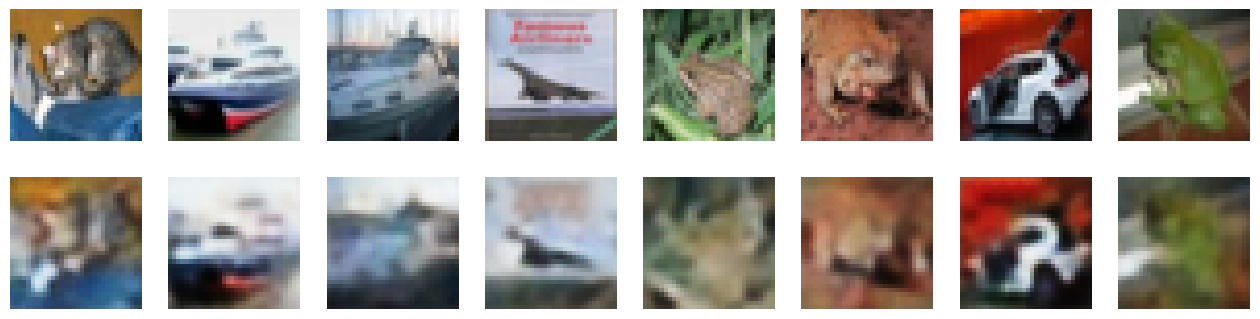

In [7]:
# 🔍 6. Evaluation – Reconstructions
model.eval()
imgs, _ = next(iter(testloader))
imgs = imgs.to(device)
with torch.no_grad():
    recons, _, _, _, _ = model(imgs)

# Show original vs reconstructed
def show_images(original, recon):
    fig, axes = plt.subplots(2, 8, figsize=(16,4))
    for i in range(8):
        axes[0,i].imshow(np.transpose(original[i].cpu().numpy(), (1,2,0)))
        axes[0,i].axis('off')
        axes[1,i].imshow(np.transpose(recon[i].cpu().numpy(), (1,2,0)))
        axes[1,i].axis('off')
    plt.show()

show_images(imgs, recons)


In [8]:
# 📈 7. Evaluation Metrics
from math import log10

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2).item()
    if mse == 0:
        return 100
    return 20 * log10(1.0 / np.sqrt(mse))

model.eval()
total_psnr = 0
with torch.no_grad():
    for imgs, _ in testloader:
        imgs = imgs.to(device)
        recons, _, _, _, _ = model(imgs)
        total_psnr += psnr(imgs, recons)
print(f"Average PSNR on test set: {total_psnr/len(testloader):.2f} dB")


Average PSNR on test set: 22.69 dB


# 📊 Results & Analysis – ReproVQVAE (Replication of van den Oord et al., NIPS 2017)

## 🔄 Training
- The model was trained on **CIFAR-10** for 10 epochs.  
- Training converged stably, with the total loss decreasing from **~0.0727** at epoch 1 to **~0.0074** at epoch 10.  
- This indicates that both the **reconstruction error** and the **VQ losses (commitment + codebook)** were minimized effectively, showing that the encoder, decoder, and codebook are learning jointly.

---

## 🖼️ Reconstructions
- The evaluation stage compared **original CIFAR-10 images** (top row) with **reconstructions** from the VQ-VAE (bottom row).  
- Reconstructions preserve the **global structure** (object category, shape, colors), but appear **slightly blurry** compared to originals.  
- This is expected because VQ-VAE compresses images into a **discrete latent space** with limited embedding capacity, which sacrifices pixel-level fidelity for higher-level abstraction.  
- Despite this, important semantic features (cars, ships, frogs, etc.) remain recognizable, confirming that the model learns **discrete, meaningful representations**.

---

## 📈 Quantitative Evaluation
- The model’s reconstruction quality was assessed using **Peak Signal-to-Noise Ratio (PSNR)**.  
- On the CIFAR-10 test set, the average PSNR was:



# 📊 Comparison of Generative Autoencoder Variants

| Model | Paper & Authors | Key Idea | Strengths | Limitations |
|-------|----------------|----------|------------|-------------|
| **Variational Autoencoder (VAE)** | Kingma & Welling (2013) <br> *“Auto-Encoding Variational Bayes”* (arXiv:1312.6114) | Introduces the **variational inference framework** with continuous latent variables and the reparameterization trick. | - Tractable training with ELBO. <br> - Stable optimization. <br> - Good reconstruction quality. | - Latents often entangled. <br> - Suffers from **posterior collapse** with strong decoders. |
| **β-VAE** | Higgins et al. (2017, DeepMind) <br> *“β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework”* | Adds a **β weighting** to the KL term to enforce stronger disentanglement of latent factors. | - Learns **disentangled, interpretable factors**. <br> - Simple modification of VAE. | - Higher β reduces reconstruction fidelity. <br> - Trade-off between disentanglement vs. sharpness. |
| **VQ-VAE** | van den Oord, Vinyals & Kavukcuoglu (2017, DeepMind) <br> *“Neural Discrete Representation Learning”* | Replaces continuous latents with a **discrete codebook** via vector quantization; avoids posterior collapse. | - Learns **discrete, symbolic representations**. <br> - Works across images, audio, video. <br> - Supports autoregressive priors (PixelCNN/WaveNet). | - Reconstructions often **blurry**. <br> - Codebook size / usage needs tuning. |

---
